# JillyAtlanta Sales Analysis
Searching for Collectors
***

## Table of Contents

* [Gather and Preprocess Data](#gather_pp)
    * [Make Etsy Dataframe](#etsy_df)
    * [Make Shopify Dataframe](#shopify_df)
* [Graph](#sales_vs_month)
    * [How Many Customers have Bought N Patterns? (Etsy)](#cust_vs_npatt_et)
    * [How Many Customers have Bought N Patterns? (Shopify)](#cust_vs_npatt_sh)
* [Who are the Collectors?](#who_are_they)
***

### Gather and Preprocess Data <a class="anchor" id="gather_pp"></a>

In [1]:
import pandas as pd
import glob
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt

We have sales data from two sources, Etsy (www.etsy.com/market/jillyatlanta) and Shopify (https://jillyatlanta.com).

We gather data from both sites, clean up and collate.

#### Etsy Dataframe <a class="anchor" id="etsy_df"></a>

<a class="anchor" id="order_items_df"></a>
Get data that includes date, order_id, and item name.  We will be matching item names to item type so we can isolate PDF sales. 

In [2]:
fiels = glob.glob('./etsy/EtsySoldOrderItems/*.csv')
df = pd.DataFrame()
for fiel in fiels:
    dfi = pd.read_csv(fiel)
    df = pd.concat([df, dfi])
#print(df.head())
df = df[['Sale Date', 'Item Name', 'Buyer', 'Quantity']]
df.rename(columns = {'Sale Date':'date', 'Item Name':'item_name',
                              'Buyer':'buyer', 'Quantity':'quantity'}, inplace = True)
#df.head()

Make a list of all items that are PDFs.

In [3]:
listings = pd.read_csv('listings_names.csv')
listings = listings[listings.PDF != 0]
pdfs = [x.strip("\" '") for x in listings.item_title.values]
for each in pdfs:
    if 'pdf'.casefold() in each.casefold(): pass
    else: 
        print(each)
        1/0
#len(pdfs)

* Identify if an item is PDF or not.
* Change format of dates, so we can group by month and sort.

In [4]:
def is_pdf(item_name):
    return item_name in pdfs

def fix_date(d):
    '''
    '12/29/14' to '2014-12'
    '''
    x = d.split('/')
    dd = '20' + x[2] + '-' + x[0]
    return dd

df['pdf'] = df['item_name'].apply(is_pdf)
df['date'] = df['date'].apply(fix_date)
df.sort_values(by='date', inplace=True)
#df.head()

Get rid of all sales that were not PDFs

In [5]:
df = df[df.pdf == True]
#df.head()

Group by buyer, and sort by number of patterns in descending order.

In [6]:
df2 = df.groupby('buyer').sum('quantity').reset_index()
df2.sort_values(by='quantity', inplace=True, ascending=False )
dfe = df2
#dfe.head(50)

N Customers vs. N Patterns, Etsy<a class="anchor" id="cust_vs_npatt_et"></a>

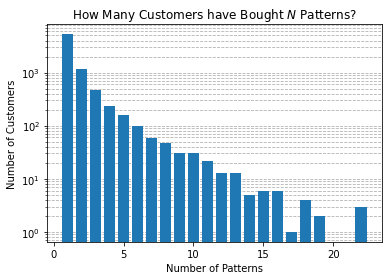

In [7]:
x, y, xp, yp = [], [], [], []
vals = sorted(list(df2.quantity.unique()))
#print(vals)
for val in vals:
    x.append(val)
    y.append(df2['quantity'].value_counts()[val])
for i in range(1, max(x)+1):
    if i in x:
        xp.append(i)
        yp.append(y[x.index(i)])
    else:
        xp.append(i)
        yp.append(0)
#for i in range(len(xp)):
#    print(xp[i], yp[i])
#print(xp, yp)
plt.grid(True, zorder=0, which='both', axis='y', linestyle='--')
plt.bar(xp, yp, zorder=3)
plt.yscale('log')
plt.xlabel('Number of Patterns')
plt.ylabel('Number of Customers')
plt.title('How Many Customers have Bought $\it{N}$ Patterns?')
plt.show()

#### Shopify Dataframe <a class="anchor" id="shopify_df"></a>

Get data that includes dates and total sales.  Refunds are aleady accounted for with these data.

In [20]:
df = pd.read_csv('./shopify/sales_per_customer.csv')
#df.head()

In [21]:
df2 = df.groupby('customer_name').sum('net_quantity').reset_index()
df2.sort_values(by='net_quantity', inplace=True, ascending=False)
dfs = df2
#dfs.head()

N Customers vs. N Patterns, Shopify<a class="anchor" id="cust_vs_npatt_sh"></a>

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 22]


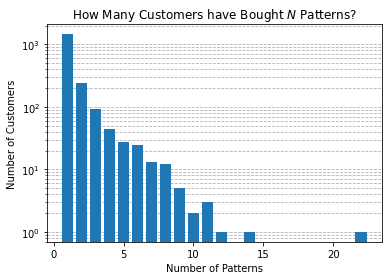

In [10]:
x, y, xp, yp = [], [], [], []
vals = sorted(list(df2.net_quantity.unique()))
print(vals)
for val in vals:
    x.append(val)
    y.append(df2['net_quantity'].value_counts()[val])
for i in range(1, max(x)+1):
    if i in x:
        xp.append(i)
        yp.append(y[x.index(i)])
    else:
        xp.append(i)
        yp.append(0)
#for i in range(len(xp)):
#    print(xp[i], yp[i])
#print(xp, yp)
plt.grid(True, zorder=0, which='both', axis='y', linestyle='--')
plt.bar(xp, yp, zorder=3)
plt.yscale('log')
plt.xlabel('Number of Patterns')
plt.ylabel('Number of Customers')
plt.title('How Many Customers have Bought $\it{N}$ Patterns?')
plt.show()

Who are they?  Etsy <a class="anchor" id="who_are_they"></a>

In [11]:
df = dfe
buyers = []
df['Collector'] = True
df.loc[df['quantity'] < 10, 'Collector'] = False
#df.head()

In [12]:
df1 = df[df.Collector == True]
collectors_dict_et = dict(zip(df1.buyer, df1.quantity))
#print(collectors_dict_et)

In [22]:
df = dfs
buyers = []
df['Collector'] = True
df.loc[df['net_quantity'] < 10, 'Collector'] = False
#dfs.head()

In [23]:
df1 = df[df.Collector == True]
collectors_dict_sh = dict(zip(df1.customer_name, df1.net_quantity))
#print(collectors_dict_sh)

***
## Try to match Etsy buyers to Shopify buyers

In [15]:
etsy_buyers = list(dfe.buyer.values)
print(len(etsy_buyers))

7598


In [16]:
dfs.head()
shopify_buyers = list(dfs.customer_name.values)
print(len(shopify_buyers))

1918


In [17]:
buyers_common_etsy = []
buyers_common_shopify = []

for each in etsy_buyers:
    for every in shopify_buyers:
        x = each.split()
        y = every.split()
        xy = [a for a in x if a in y]
        if len(xy) > 1:
            buyers_common_etsy.append(each)
            buyers_common_shopify.append(every)

In [18]:
dfe_common = dfe.loc[dfe['buyer'].isin(buyers_common_etsy)]
dfe_common.shape

(296, 4)

In [19]:
dfs_common = dfs.loc[dfs['customer_name'].isin(buyers_common_shopify)]
dfs_common.shape

(306, 5)